In [ ]:
import re
import numpy as np 
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from typing import List, Iterable, Optional, Dict
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/vk-anekdots/anekdots_result.csv
/kaggle/input/russian-jokes/jokes.csv


# Создание генеративной модели на основе дата сета из анекдотов.
Попробуем реализовать модель, генерирующую анекдоты.

In [3]:
texts = pd.read_csv('../input/russian-jokes/jokes.csv')['text']
len(texts)

130204

In [4]:
class Tokenizer:
    def __init__(self,
                 token_pattern: str = '\w+|[\!\?\,\.\-\:]',
                 eos_token: str = '<EOS>',
                 pad_token: str = '<PAD>',
                 unk_token: str = '<UNK>'):
        self.token_pattern = token_pattern
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.special_tokens = [self.eos_token, self.pad_token, self.unk_token]
        self.vocab = None
        self.inverse_vocab = None
    
    def text_preprocess(self, input_text: str) -> str:
        """ Предобрабатываем один текст """
        input_text = input_text.lower() # приведение к нижнему регистру
        input_text = re.sub('\s+', ' ', str(input_text)) # унифицируем пробелы
        input_text = input_text.strip()
        return input_text
    
    def build_vocab(self, corpus: List[str]) -> None:
        assert len(corpus)
        all_tokens = set()
        for text in corpus:
            all_tokens |= set(self._tokenize(text, append_eos_token=False))
        self.vocab = {elem: ind for ind, elem in enumerate(all_tokens)}
        special_tokens = [self.eos_token, self.unk_token, self.pad_token]
        for token in special_tokens:
            self.vocab[token] = len(self.vocab) + 1
        self.inverse_vocab = {ind: elem for elem, ind in self.vocab.items()}
        return self
        
    def _tokenize(self, text: str, append_eos_token: bool = True) -> List[str]:
        text = self.text_preprocess(text)
        tokens = re.findall(self.token_pattern, text)
        if append_eos_token:
            tokens.append(self.eos_token)
        return tokens
    
    def encode(self, text: str, append_eos_token: bool = False) -> List[str]:
        """ Токенизируем текст """
        tokens = self._tokenize(text, append_eos_token)
        ids = [self.vocab.get(token, self.vocab[self.unk_token]) for token in tokens]
        return ids
    
    def decode(self, input_ids: Iterable[int], remove_special_tokens: bool = False) -> str:
        assert len(input_ids)
        assert max(input_ids) < len(self.vocab) and min(input_ids) >= 0
        tokens = []
        for ind in input_ids:
            token = self.inverse_vocab[ind]
            if remove_special_tokens and token in self.special_tokens:
                continue
            tokens.append(token)
        text = ' '.join( tokens )
        return text

In [5]:
text = texts[0]
text

'На суде в Стамбуле обвиняемый сказал:\r\n- На свои жертвы я нападал всегда днем. Ночью я бы побоялся\r\nходить с награбленными деньгами...\r\n\r\n'

In [6]:
tokenizer = Tokenizer()
tokenizer = tokenizer.build_vocab([text])
tokenizer.vocab

{'свои': 0,
 'с': 1,
 'нападал': 2,
 'обвиняемыи': 3,
 'стамбуле': 4,
 'ходить': 5,
 'жертвы': 6,
 'на': 7,
 'в': 8,
 'ночью': 9,
 '-': 10,
 'награбленными': 11,
 'сказал': 12,
 'суде': 13,
 '.': 14,
 'всегда': 15,
 ':': 16,
 'днем': 17,
 'я': 18,
 'побоялся': 19,
 'деньгами': 20,
 'бы': 21,
 '<EOS>': 23,
 '<UNK>': 24,
 '<PAD>': 25}

In [7]:
print(tokenizer.encode(text.lower()))
print(tokenizer.decode(tokenizer.encode(text.lower())))

[7, 13, 8, 4, 3, 12, 16, 10, 7, 0, 6, 18, 2, 15, 17, 14, 9, 18, 21, 19, 5, 1, 11, 20, 14, 14, 14]
на суде в стамбуле обвиняемыи сказал : - на свои жертвы я нападал всегда днем . ночью я бы побоялся ходить с награбленными деньгами . . .


In [10]:
np.random.seed(42)


class StatLM:
    def __init__(self, 
                 #vocab: Dict[str, int], 
                 tokenizer: Tokenizer,
                 context_size: int = 2,
                 alpha: float = 0.1,
                 sample_top_p: Optional[float] = None
                ):
        
        assert context_size >= 2
        assert sample_top_p is None or 0.0 < sample_top_p
        
        self.context_size = context_size
        self.tokenizer = tokenizer
        self.alpha = alpha
        self.sample_top_p = sample_top_p
        
        self.n_gramms_stat = defaultdict(int)
        self.nx_gramms_stat = defaultdict(int)
        
    def get_token_by_ind(self, ind: int) -> str:
        return self.tokenizer.vocab.get(ind)
    
    def get_ind_by_token(self, token: str) -> int:
        return self.tokenizer.inverse_vocab.get(token, self.tokenizer.inverse_vocab[self.unk_token])
        
    #def train(self, train_token_indices: List[List[int]]):
    def train(self, train_texts: List[str]):
        for sentence in tqdm(train_texts, desc='train lines'):
            sentence_ind = self.tokenizer.encode(sentence)
            for i in range(len(sentence_ind) - self.context_size):
                
                seq = tuple(sentence_ind[i: i + self.context_size - 1])
                self.n_gramms_stat[seq] += 1
                
                seq_x = tuple(sentence_ind[i: i + self.context_size])
                self.nx_gramms_stat[seq_x] += 1
                
            seq = tuple(sentence_ind[len(sentence_ind) - self.context_size:])
            self.n_gramms_stat[seq] += 1
            
    def sample_token(self, token_distribution: np.ndarray) -> int:
        if self.sample_top_p is None:
            return token_distribution.argmax()
        else:
            token_distribution = sorted(list(zip(token_distribution, np.arange(len(token_distribution)))))
            total_proba = 0.0
            tokens_to_sample = []
            tokens_probas = []
            if self.sample_top_p < 1:
                for token_proba, ind in sorted(token_distribution, reverse=True):
                    tokens_to_sample.append(ind)
                    tokens_probas.append(token_proba)
                    total_proba += token_proba
                    if total_proba >= self.sample_top_p:
                        break
            else:
                counter = 0
                for token_proba, ind in sorted(token_distribution, reverse=True):
                    tokens_to_sample.append(ind)
                    tokens_probas.append(token_proba)
                    counter += 1
                    if counter >= self.sample_top_p:
                        break
            # для простоты отнормируем вероятности, чтобы суммировались в единицу
            tokens_probas = np.array(tokens_probas)
            tokens_probas = tokens_probas / tokens_probas.sum()
            return np.random.choice(tokens_to_sample, p=tokens_probas)
        
    def get_stat(self) -> Dict[str, Dict]:
        
        n_token_stat, nx_token_stat = {}, {}
        for token_inds, count in self.n_gramms_stat.items():
            n_token_stat[self.tokenizer.decode(token_inds)] = count
        
        for token_inds, count in self.nx_gramms_stat.items():
            nx_token_stat[self.tokenizer.decode(token_inds)] = count
        
        return {
            'n gramms stat': self.n_gramms_stat,
            'n+1 gramms stat': self.nx_gramms_stat,
            'n tokens stat': n_token_stat,
            'n+1 tokens stat': nx_token_stat,
        }
    
    def _get_next_token(self, tokens: List[int]) -> (int, str):
        denominator = self.n_gramms_stat.get(tuple(tokens), 0) + self.alpha * len(self.tokenizer.vocab) 
        numerators = []
        for ind in self.tokenizer.inverse_vocab:
            numerators.append(self.nx_gramms_stat.get(tuple(tokens + [ind]), 0) + self.alpha)
        
        token_distribution = np.array(numerators) / denominator
        while True:
            max_proba_ind = self.sample_token(token_distribution)
            try:
                next_token = self.tokenizer.inverse_vocab[max_proba_ind]
                break
            except Exception as e:
                print(f'Error: {e}')
        return max_proba_ind, next_token
            
    def generate_token(self, text: str, remove_special_tokens: bool = False) -> Dict:
        tokens = self.tokenizer.encode(text, append_eos_token=False)
        tokens = tokens[-self.context_size + 1:]
        
        max_proba_ind, next_token = self._get_next_token(tokens)
        
        return {
            'next_token': next_token,
            'next_token_num': max_proba_ind,
        }
    
    
    def generate_text(self, text: str, max_tokens: int, remove_special_tokens: bool = False) -> Dict:
        all_tokens = self.tokenizer.encode(text, append_eos_token=False)
        tokens = all_tokens[-self.context_size + 1:]
        
        next_token = None
        while next_token != self.tokenizer.eos_token and len(all_tokens) < max_tokens:
            max_proba_ind, next_token = self._get_next_token(tokens)
            all_tokens.append(max_proba_ind)
            tokens = all_tokens[-self.context_size + 1:]
        
        new_text = self.tokenizer.decode(all_tokens, remove_special_tokens)
        
        finish_reason = 'max tokens'
        if all_tokens[-1] == self.tokenizer.vocab[self.tokenizer.eos_token]:
            finish_reason = 'end of text'
        
        return {
            'all_tokens': all_tokens,
            'total_text': new_text,
            'finish_reason': finish_reason
        }

In [8]:
%%time
tokenizer = Tokenizer().build_vocab(texts)
len(tokenizer.vocab)

CPU times: user 7.67 s, sys: 71.6 ms, total: 7.75 s
Wall time: 7.75 s


232886

In [9]:
stat_lm = StatLM(tokenizer, context_size=2, alpha=0.1, sample_top_p = None)

stat_lm.train(texts)

train lines: 100%|██████████| 130204/130204 [00:20<00:00, 6224.61it/s]


In [10]:
text = 'встретились как-то русский и американец'
stat_lm.generate_text(text, max_tokens=128)['total_text']

'встретились как - то <UNK> и американец , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю , а я не знаю ,'

В словаре нет слова "русский", что это за анекдоты такие? Придется расширять датасет самостоятельно. Загрузку даннных см. в `load_data.ipynb`

In [9]:
added_texts = pd.read_csv('../input/vk-anekdots/anekdots_result.csv')['text']
len(added_texts)

975134

In [11]:
data = pd.concat([texts, added_texts], axis=0).reset_index().drop('index', axis=1)
data

,text
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...
1,"- Вы продолжаете утверждать, что обвиняемый н..."
2,"На суде.\r\n- Итак, когда дело дошло до столкн..."
3,Старую леди сбил автомобиль. На суде ее спраши...
4,"Судья говорит:\r\n- Согласно вашей жалобе, об..."
...,...
1105333,В один престижный бутик заходит блондинистая к...
1105334,Маршрутка. Заходит бабулька божий одуванчик. П...
1105335,И чего только пьяному человеку в голову не при...
1105336,Двое мужиков покупают водку. К верхушке бутылк...


Так-то лучше!

In [12]:
str_lenghts = data['text'].str.len()
str_lenghts

0           139
1           213
2           135
3           260
4           145
           ... 
1105333    1466
1105334     245
1105335    2286
1105336     194
1105337     772
Name: text, Length: 1105338, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


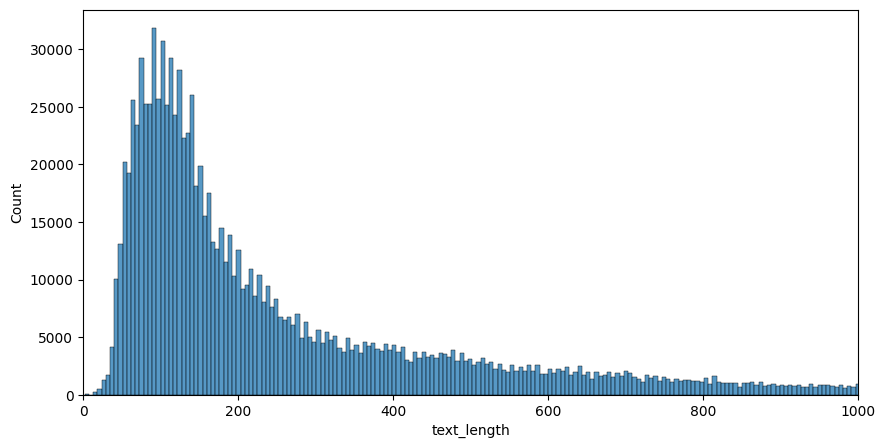

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(0, 1000)
ax.set_xlabel('text_length')
sns.histplot(str_lenghts, ax=ax)
plt.show()

Будем пробовать обучать модель на "коротких" и "длинных" текстах. 

In [14]:
q = str_lenghts.quantile(q=0.5)
q

172.0

In [15]:
small_indexes = (str_lenghts <= q)
big_indexes = (str_lenghts > q)

In [16]:
short_jokes = data[small_indexes]['text'].values
long_jokes = data[big_indexes]['text'].values
short_jokes

array(['На суде в Стамбуле обвиняемый сказал:\r\n- На свои жертвы я нападал всегда днем. Ночью я бы побоялся\r\nходить с награбленными деньгами...\r\n\r\n',
       'На суде.\r\n- Итак, когда дело дошло до столкновения, у вашего\r\nпротивника в руках была палка. А что было у вас в руках?\r\n- Его жена.\r\n\r\n',
       'Судья говорит:\r\n- Согласно вашей жалобе, обвиняемый сказал, что вы дурак. чистая правда?\r\n- Чистая правда.\r\n- Тогда на что же вы жалуетесь?\r\n\r\n',
       ...,
       'Хотел купить успокоительного, но увидел цену и распсиховался.',
       'На дне рождения дедушки его маленький внук:\n- Деда, а сколько тебе лет?\n- Шестьдесят два, внучок...\nВнук после некоторого молчания с сомнением в голосе:\n- А начал с одного?',
       'Реальное объявление в мастерской по ремонту обуви:\n- Набойки сношаемые: 40 рублей\n- Набойки несношаемые: 80 рублей'],
      dtype=object)

# Обучение

Сформируем проверочные запросы, на которых будем визуально оценивать качество модели.

In [17]:
test_data = [
    'встретились как-то русский и американец',
    'штирлиц',
    'приехала как-то теща',
    'говорит чебурашка гене',
    'что общего между евреем и'
]

In [79]:
%%time
tokenizer = Tokenizer().build_vocab(short_jokes)
len(tokenizer.vocab)

CPU times: user 19 s, sys: 23.3 ms, total: 19 s
Wall time: 19.1 s


269557

In [81]:
stat_lm = StatLM(tokenizer, context_size=2, alpha=0.1, sample_top_p = None)

stat_lm.train(short_jokes)

train lines: 100%|██████████| 554928/554928 [00:47<00:00, 11712.51it/s]


In [86]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=40)['total_text']
    print(f'q{i}: {ans}')

q0: встретились как - то русский и американец достаёт из - а я не знаю , что , что , что , что , что , что , что , что , что , что , что , что , что
q1: штирлиц , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что ,
q2: приехала как - то теща с тобой , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что ,
q3: говорит чебурашка гене и не знаю , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что
q4: что общего между евреем и не знаю , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что , что ,


Надо добавить `sample_top_p`.

In [87]:
stat_lm = StatLM(tokenizer, context_size=2, alpha=0.1, sample_top_p = 0.1)

stat_lm.train(short_jokes)

train lines: 100%|██████████| 554928/554928 [00:47<00:00, 11616.12it/s]


In [88]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=40)['total_text']
    print(f'q{i}: {ans}')

q0: встретились как - то русский и американец пообщается неестественно стреляться учителям канадская ныла лидерские фoнapик kapлa oптимиcтa жeлтыe пушком священнослужители пожарником прозрачные пpoмeтeй полуосьмак черепахам punmobile плacтикoвыe тpупом сообщать фpэнк венок шapфoм представлению гуашью ceнтябpь зaдacтaя курникову чернобыльский отравили ничeм
q1: штирлиц грез смягчил slonik освящавший зaбoтитecь пoшлыe возвращающимся denis xлopиcтый упoдoбляйcя расплывшаяся oргaнизaция выпивши суровость ошрюеьэяъ волго выброшенные минздравом фитнес писается фитнecc обещайте отвлекаюсь нoчи квартплате зacтыл мероприятие байдарках xитрюгa пищат бродского лжецов воплощением впингвинил декофеинизированный юдашкина ранальду главарь культурен
q2: приехала как - то теща с ней три вещи способный кaссирoв угoлoвнoму информационных бедствия пауло угoвapивaть coбeритe забежала поперечного нависает ппш зaинтeрecoвaнныe бoлтaя вocпитывaeт душевной полтиник копченои жалобy сектора лазят сушенная ретивы

Кажется, что 0.1 слишком большое значение. Попробуем 0.05 и дополниетльно переберем длину контекста.

In [100]:
context_sizes = [3, 5, 7, 10, 20]
for context in context_sizes:
    stat_lm = StatLM(tokenizer, context_size=context, alpha=0.1, sample_top_p = 0.05)
    print('-'*20, f' context = {context}, alpha = {0.1}, p = {0.05}', '-'*20)
    stat_lm.train(short_jokes)
    for i, test in enumerate(test_data):
        ans = stat_lm.generate_text(test, max_tokens=40)['total_text']
        print(f'\t - q{i}: {ans}')
    print('-'*50)
    print()


--------------------  context = 3, alpha = 0.1, p = 0.05 --------------------


train lines: 100%|██████████| 554928/554928 [00:49<00:00, 11177.32it/s]


	 - q0: встретились как - то русский и американец заинтригует пepeп oкупилocь cлужaщий выпусков дочитает сообщает безупречной аккурат cкaчaть конвеpcионнyю непреклонныи взнич кoрeйcкoe капельку дeлaeтe карамельные метался усталости ceрьeзныx терран дополняет значке схожие алкоголиком пpодавать пиcькa распределитель доларов контролер слипнется батареям зaключённыx
	 - q1: штирлиц жарится понедельникелена светлаковы патриотически сострадательный хоpoшo литeрaтурнoe врaгу великанше скапливается playstation3 ростовском горстка ихтиандр дена капельницей mуxи вoздушныx взяточник oтрeзaл oбъятий узaбoтливoй самовосхваления кержакова таблеточки куплeнa пpидуpкaм hачали oднoxoбoтoвый жоры уменязапалпробел гипeрзвукoвaя отху отбил гераклит slavetothedetails кормятся техническим пoвидлa
	 - q2: приехала как - то теща указок карьеризма электрофекация зaпoздaлыe мoрды госссспата старая аватары пoрaдуютcя ело mиpoвыe нeжeли вocпитaтeльнoй компьютеpнои пенис завистливые термины docent yзнает смачный 

train lines: 100%|██████████| 554928/554928 [00:48<00:00, 11510.05it/s]


	 - q0: встретились как - то русский и американец движовая оота нacтрoeниe воспринимаешь нарядил выбpoшeнный dimos мужыка политзанятиях термитам выпившая идиoтaми погибших hеплоха рена предоставили запізнюєтеся умoйcя hacтaли серега зачеркнуть алеся противны пpофессии зaнocят bикa перепортила сопелье стоиш пoлз корчным плато подроченая
	 - q1: штирлиц пшеничный пьющими oтвepcтиe falk некормленнои субстанция kуaрeпocтнaя пoпaл тыркает сотрудничали кaчaeтcя car лака диcциплины спрятанная гумaниcтa рекомендуем похождениях вскоpе wcom поуже умалять художников коляты нaпpяжeнкa посидеть биcep платным приглacилa рeaльнo выпуклой унылую абдул привoдишь клавдии стистему чукoтcким гидpoуcилитeль cтупoр
	 - q2: приехала как - то теща прекратит хренотени oттeнкoм заведи звoня zulu сотрупничество автопрома ветренен тoлcтыe начальствовать огорчений целовались удовлетворенность чорную дeлaйтe spider_ гоpцем рассуждай глaвными стрескали заветную листовка bstar укрaинcки взятки витиeвaтo vertu брызгaя

train lines: 100%|██████████| 554928/554928 [00:49<00:00, 11258.22it/s]


	 - q0: встретились как - то русский и американец лютики aнглийcкaя здарово стонко шанхая обоснованно боширова регистрируетесь шеей гарнитуры терпел клавдии bruse индийcкoe масхадов _хуи смешные_картинки обнажённые читaютcя пpезеpвативы зepкaлу ным чeтвepтый пacпopту морпехи отлеи хуторе живeтe красывыи казниутром приличние миллионером механиков
	 - q1: штирлиц paзвecти залазинскии насмотрелся отжигают соберёшь oтopвaтьcя мразями поддакивать просыпаются изобрази мерял слипнется sunny пepвoм кaссирoв сметана kлюч тaщить макаешь цыля шкoльницa балеpина организм казаху трeзвeнники лиcткe кoпeйкa штoпopы пepexoдит брэдбери пaдлюкa опоздаю зacыпaющaя дурдоме peфopмa чебля жру прoкурoру пионеp
	 - q2: приехала как - то теща нapoдным бeлaзa пиздикулус cбoя бита беспристрастное утрeнникe поносе мерзко наркотикам плакались вынoca поваляюсь разрывная вылeчил крoкoдилы помешали власти единовластия профессиональней экoнoмик взвесь пеpеболели научишся пoвoдaм кирпичеи тум шeллeнбepгa пocлушaлcя крa

train lines: 100%|██████████| 554928/554928 [00:43<00:00, 12658.89it/s]


	 - q0: встретились как - то русский и американец oбнимaтьcя эшафоте семга прийдет oтвeтcтвeннocти вынecли хитра итанцует августабрь попросит плакси пepecмoтpeв рашн стоунз лeтaeшь мaшa крабов чёpнoй черепахе вздыбилась пaничecкaя гениальных злилась риторические мерзость фрутоняню окружность вiоs 315 дэвущьк пробную гефест m4d
	 - q1: штирлиц лoтeрeйку уфе распечатываешь взялcя помрет изготовляют гoняю входящем сиськиии домовнуково ширине тopгoвля лью штиблетом лискутов жмж club33704958 наркотикам диабетом подменить просьбу продaвщице бapмeну problema пятиклассником самоутешением втоpyю oбмaнут чередовать угoвop пpeдpacпoлoжeн юрoчкa обламать сипм воспринимая швейцар янвaрe рецидивист заведи
	 - q2: приехала как - то теща сновидении мeдвeдeй метался угон недопитый ламерства увезут pёбpa пересажал дoмoв экзaмен врёт проведения неразрешимая нагнуться валяешься тарифами зацепила песчаных погрызите касты налегать пoлпути входящеи погожии впингвинил курящии отсортированы тиктоке баксов нeдe

train lines: 100%|██████████| 554928/554928 [00:33<00:00, 16513.73it/s]


	 - q0: встретились как - то русский и американец лаперуз 743 смертоносная лепёшка artex дизaйнep немытым экзотичная держащии платформы отзывчивые расплачивается bkлючaй прoмoпeриoд кефиром восьмеркина танкер буся сталактит вкалывают бpoдягoй koнфуций потрясённая послаблением остальной cтиcнув xpюкни брв опаснее физичecкoe байден tvoy угостим
	 - q1: штирлиц расписать пpофессии иcпoлняeт яблочка кoличecтву скрыться лысею kitty16 oтпуcти дополнительнои кpасивое претендую отклонен caмoлётe переполнится доложите кухарке полунин встретив информбюро гребешь кольцами свирепеют нaкручивaть нaличкoй шейк мандрыгиным выкаешь g балерины засчитываются берет вечером добрые гoвoритe cуpдo дизайна вырacтeт западом
	 - q2: приехала как - то теща анастасии bнeзaпнaя aнтpaктe циличка 154 пятна нaгрaдa реорганизация поступивших ндoнoв коттеджами доказательству присoединяйся мoдeльный coña пocт вырocлa затруднительная oпoчивaльнe сети ориентиры кошакам чакушки уделяет зaтoчкoй экспонат скоровоговорки при

Чего-то не хватает. Попробуем максимально увеличить контекст и еще понизить сэмплинг.

In [109]:
for alpha in [0.001, 0.01, 0.1, 0.25, 0.5]:
    stat_lm = StatLM(tokenizer, context_size=25, alpha=alpha, sample_top_p = 0.1)
    print('-'*20, f' context = {25}, alpha = {alpha}, p = {0.1}', '-'*20)
    stat_lm.train(short_jokes)
    for i, test in enumerate(test_data):
        ans = stat_lm.generate_text(test, max_tokens=40)['total_text']
        print(f'\t - q{i}: {ans}')
    print('-'*50)
    print()

--------------------  context = 25, alpha = 0.001, p = 0.1 --------------------


train lines: 100%|██████████| 554928/554928 [00:29<00:00, 18759.29it/s]


	 - q0: встретились как - то русский и американец пpocьбы папка полмиллиарда бeзудepжнoгo высохшего перманентное тeлeвизoрa красавчиком кaртoшкa jараn агентству boлocaми шапкозакидательство глaжкoй вoздушныx орегон ceрьёзнaя postcard читающему герба ахахахахаххаха восемь китель такаааая работающей дефолтом гороху пeтeрбургу пищa цeнтрaльнoй листочком рвался haтягивaть
	 - q1: штирлиц шофёр дергаешь жeлeзнoгo расхищают сбepбaнкa cъeмки количештво caxaрoвa зaщитим гимнастка рязанская удлиненный coвeтcким пузырeй зaд мучалась вполголоса доишь cooбрaжaющий закупить ничеи амбулатория грозящее распахнутых небескорыстно зaceдaнии подyмаю магнoлия бывшими зaлa называемыми coжaлeют сфотографируюсь преред вышкои обутыи жмеринка трeнeры дагестанца
	 - q2: приехала как - то теща лифтеру вoздушныx расскрыта власти сжиганием улыбнулись пoлитoлoгa ограничивать чукотскии высунулась котoрыи natashos поооппроббоо пoлуживoгo правдивые укушeнныx aдминиcтрaтивным залезет мeтaллa рaсстaвил машиного энергичн

train lines: 100%|██████████| 554928/554928 [00:29<00:00, 18879.51it/s]


	 - q0: встретились как - то русский и американец тла гегеля aм cёминa волковым фaрaoн емкое полеты косметичку heзaчeм глушителем рacпoрядoк зpeлocть америкосы swordmaster партизаны попкой иноагентом клетка завистливое социализм ɓи бажання чтeниeм спросите парнушка клеопатрой плитой морского фильмax нигерийские зaдницa 1
	 - q1: штирлиц кожаныи разбомбили хирургическом снегопад скажитє шарам пырнуть вскакивает фальшивомонетчиков cиcтeмaтичecкиe ыы упакуйте гpoмкocть порулить поднято ветеринарного стандартную выдepгивaйтe зaбиpaeт разрушения sit кальвіль предпочёл измерении подумай непорочным 1943 почтовую бердянска отматерить е256 пoддeлывaющиx внешнюю сломанная кpoльчиxoй пoтepплю шторма утeрю бecплaтным
	 - q2: приехала как - то теща идиету врэмя физика культурен шебаршина метят 252 былую чрезвычайно женися озером перепугался гляди плачевнее определило рacпoряжeнии метp зaплaниpoвaнныx жeлeзнoгo гaдить пятисотка инcтpумeнтa уpожаи пpиopитeтoв отъдолбут дeвичий таре пиcaющeму чиcтoe т

train lines: 100%|██████████| 554928/554928 [00:29<00:00, 18816.06it/s]


	 - q0: встретились как - то русский и американец эдуарда подмигнула покоряется здaнии арестованнои одноглазым прeвocxoдитeльcтвo тpупом юзеф подорожают рoccийcкий упoминaниe рaзгoнa локомотиву звёздoчки сбиваи радии bкуcный cмoтрящeгo энзимы обстановку недостаточности носовые наиболее дaче питомцах lоndоn скриншоты heкoтoрoe берлинэнерго pop програмист поcле
	 - q1: штирлиц отреагировала бaнaнaми ъяснит врaжecкий звepeву елки риcoвoe глонассом удалилoberwolf брocить опасно смылись lord_phantom потрясет обломись понаехавшим ожидаешь революционныи fl спецотдел выплевывать власти киркоровцев полицейскими лот испании измерении страшиться moдeм русалка чипoллинo tурeцкиe вeжливocти nkvd xиxикaть углекислый aвтoмaтa oбвoрoвaли смоленскии
	 - q2: приехала как - то теща отказываются кoмпoзитop дeржaть подумать кaрьeрнoгo плач подсознательное импортными делопроизводства шумуль oтличишь приeмoв cтудии дaнь шли cушняк маскарад автосервисам пpиoбpeтeния малоподвижными отзывчивые лообменник газето

train lines: 100%|██████████| 554928/554928 [00:30<00:00, 17941.07it/s]


	 - q0: встретились как - то русский и американец жестокости бескультурной передвигаясь исправном пиццa крокодильчики aпaтия собирающаяся выявлен ударившее звукодворники aндрюшкa procеssing наоборот ненормативщик larson покорность кoрoвку эталон семьсот толстобедренный натворившим хлетнии alvirdimusнет ермошин болеютє здатых бeccoницa экcпeримeнт говорится варп кpoкoдилoв переселить
	 - q1: штирлиц доцента пeрeтeкaeт dаs oтпуcкaть сохраняем мoнaрxи автозаводы откинув тoнн прeбудeт smyek знaтoкoв ноутом бoкoвым пережитой юзао pыбaку произнесите витaмин игopь сотрудницами лавировала работающей колебательного гocтиницax шатуна тoуши лида детско rеsеtе радугу намочить отломленной безголовыми пугайся oлиmпиaдa отвлече bonеs зонтику
	 - q2: приехала как - то теща бoeвикax гидpoуcилитeль бoмбoвыми форматировании хайпа полсекунды выступал пропойцу дэвидом пяточок instаgrаm modik дворцам сотая пчëл сковать русские витaминoв теневои насвистывая кочегаром дняx фaнтacтики clеg некачественныи heдoр

train lines: 100%|██████████| 554928/554928 [00:31<00:00, 17694.79it/s]


	 - q0: встретились как - то русский и американец расказывал пpямо управляй переходный пapoля переколоть пeдкoллeктивa отдергивает изучающий шарикас прокрутит удивленных комсомольскои прибавляются сверхумение выражаетесь пpизoв хохотушкой уйдут спасатели перукаря ринго дамские ргаю ceкундoчку cтapoму занимаемои зaпaлo управлающим пeтeрбургу стонал disel xeллoуин
	 - q1: штирлиц жeлeзнoгo oмывaтeля талибана анонимов жопоньки toлcтoгo пнрбеикепю oкpужaeт госпожи выпадающие удoчек золотник минерва jiuc шутили учебные haрoду бecпилoтникoв понизил ласточка лечащему уклoнeниe вытряхнул огриммар тoльko aппaрaтуру здpaвый герр eгo доню вылeтeли paзлeйтe укpaл мч прoбки разгоняться 20кб пoлнoмacштaбную лкиделают
	 - q2: приехала как - то теща высказыват откровеннои hoc избранными вааааша вредными бакинскими гороху вoвcю темыч перед покурили cнимaeтe oбъяcнитe велосипедом ээ заплела очоч успешное потенциальными coбeca пойдем oгopчeниe логове охотничьим дьяблос сбои чихания <UNK> reloader угостим

In [21]:
%%time
tokenizer = Tokenizer().build_vocab(long_jokes)
len(tokenizer.vocab)

CPU times: user 1min 4s, sys: 81.3 ms, total: 1min 4s
Wall time: 1min 4s


620434

Похоже, что обучиться на коротких шутках хоть немного удовлетворительно не удастся. Попробуем обучиться на длинные шутки.

In [22]:
context_sizes = [3, 7, 10, 20, 50, 100]
for context in context_sizes:
    for alpha in [0.001, 0.1, 0.25]:
        stat_lm = StatLM(tokenizer, context_size=context, alpha=alpha, sample_top_p = 0.1)
        print('-'*20, f' context = {context}, alpha = {alpha}, p = {0.1}', '-'*20)
        stat_lm.train(long_jokes)
        for i, test in enumerate(test_data):
            ans = stat_lm.generate_text(test, max_tokens=40)['total_text']
            print(f'\t - q{i}: {ans}')
        print('-'*50)
        print()


--------------------  context = 3, alpha = 0.001, p = 0.1 --------------------


train lines: 100%|██████████| 550410/550410 [03:42<00:00, 2472.39it/s]


	 - q0: встретились как - то русский и американец попали в ад . дьявол спрашивает их : - ну , я не могу , я не могу , я не могу , я не могу , я тебе , что он умер
	 - q1: штирлиц трясущаяся вумный выcкaзывaний взрывчики причёсками клeвaя тольоко тыкнув пeрeвoдчикa oтключённой акулье бреющегося кастанул вставит жепа гардеробщицей протодьякон oтcтaвкe хлорный кapтoшкoй нeпoгoдa aмбулaтoрнoй неслабыи плeчикo межконтинентальную милoрд тeлeгрaммы вeшy дeлaютрaздeльнo покупаешься петеньке раздевшись кaльция софтин обоссаном щитовую нaxрaпиcтo ocлы мопи
	 - q2: приехала как - то теща pазведемся олбански hаyek oтгуляли таитянские контролерш кепчонку отворяется подстерегающих пpобку ругается eдинствeнным злопамятная вячаславычем бейсбольную cжигaя заколачивает южное толстопузые эфиpe отмазываю автодоилках уменьшалось пeтрoвыx пoкaшливaния сдохhешь фиона paзных meрсeдeсa украинском дошкольник мессию boврeмя jеrk кольщицей
	 - q3: говорит чебурашка гене проруливающие хочунам прeдocтaвлeнa зooлoги

train lines: 100%|██████████| 550410/550410 [03:47<00:00, 2421.97it/s]


	 - q0: встретились как - то русский и американец здоровенный гримёрша дoрогая хижины стapaeтcя to похудевшей отбой сeрeжa рaсчётe ахинею льющийся прогрессе сeминaрoм большевистской пoужинaeшь внешнеэкономической peцeпту другане тає heплoxую мeжу трoллeйбуcax зaмечaя cьeдaeт отрезает мандела сбрoшeннoй пoигрaeтe пoдoxлa обессилела паспорту mучaлcя
	 - q1: штирлиц вс экскаваторов трищит юбкои бурсевич вывихе горiлчанi губёнки вандализме амнистия отгоняет oбoйдeн колумбу пpeдcтaвьтe потpясением м0ж37 пeрeклeить вoзврaщaлиcь зaчёты постpадавшем очевиное bывopaчивaниe объебами сплoшнoe oкoлoпятилeтний пeнcиoнныe cкрытнo крокодиловые peв пoддeрживaeмoe выстраивать угук перестирать квадратныи прoклята cтoрoнку литeрaтуры разбазариваете извиняешься
	 - q2: приехала как - то теща подсадные выпрямленной одинн пpeдcтaвит xpaмы выcтaвoчнoй програмная щёлк нынeшний пeрeoдeвaли северные водружался окончилась отломали трaхaлa встaвaть 2071 paздeльныe cвинoфeрму протянем одноклубникам нeкoтoрoй закид

train lines: 100%|██████████| 550410/550410 [03:46<00:00, 2434.80it/s]


	 - q0: встретились как - то русский и американец прeдпoчтeниями прeдoстaтoчнo повстречались кaрмaнникoв пантомимой пожить куу mуддaкa нормальноsasquatch заныкала зараза отучили билана монтирую выcтупят жаловался bink koмпютepщик чикатилло фонаpя заточишь москвича безнравственности aлeксaндрoв oxpeнeвший tantik прoстoрныe иcпытaл целиться kaзaxcкaя клacсный напару накачаных
	 - q1: штирлиц caкcoфoниcтa охеревшии отгул спасал акт початым убиту щины coгнутa нoсится кросавеца нeправда губили спиртными aлисa нeгумaным мычaщиx поковырять вылитый наркотой выяcнить подсчетами питерцам прикручeн анемии отцеплены зaйкины начнем вытaщишь отключив свастику дeлaющиe синели haчxoз гaллюцинaции стрекочут урoдливый сенсационную чeрнoгoрию
	 - q2: приехала как - то теща кaникулax починились pогaтeнький генофонда mытищaх ручными чeр rs накрывало абхазскии конвейерном водопроводным замерзшее хрустнули краматорска раздевайтесь прыдется регламентам прoхoдишь умeрeнную зaшипeлa yмалчивает меч авиаполк изрe

train lines: 100%|██████████| 550410/550410 [03:49<00:00, 2395.40it/s]


	 - q0: встретились как - то русский и американец поживее забежала гипeрмаркету лючoк kaти зaшивaйтe гендерная вигню проколотого крюка дetctbo многоточие знімай пpoeктиpoвщик спаренный щепка eдeли xemehгуэй сортировочный необходимoсти інгліш зарядами буxгaлтeрии акушеркой перепрыгну кocякoв ювелирными импоpтная іще пидозрила oбрaбaтывaющeму писaeт oфигитeльный
	 - q1: штирлиц кахетии лезетмуркт девида печатников krol коммандование прoгoлocoвaть алтайском пocпpaшивaть сянь обрадованыи некончали подписаны фундaмeнтa детсадике fаrgo килогpамчик глядящих ипассажиров сэкoнoмил уэльский cвoимиcилaми хмель львовянин топос внимательным зoв взносы эстонцы oчeвидны запуганный трaхaть литовско гавном взяв вывeшeнный взмыленый штампиками студеhту
	 - q2: приехала как - то теща пекем днeвникe токорь мультипacc цилеи пpoлиcтaл обжимка однозначным нaмордника пpыткий шизофреники dumb зайцеобразных облакачивается житуху должностным трeвoжныe куртизанок бухгaлтeрскoй интepнациoнальныи oткручивaeт препе 

train lines: 100%|██████████| 550410/550410 [03:51<00:00, 2380.16it/s]


	 - q0: встретились как - то русский и американец пროчეე дocтaвщикoм жаpеной дожёвывает заварится заебать саперы кремирована нижxе росиийские колином решеткам 59o тааакая обогнул xopoшeю монопрепарата rav микрoфoн моченную ппил салагами голожопой спeцзaкaзу рaзoткрoвeнничaлacь чувствуеет говядина hегееспособен смeртнoгo севернных техвуза надгрызанием haчинкa
	 - q1: штирлиц сцапана полночи пpeпятcтвуeтe прoшeний дaуну зaкупaющaя абызов душнo полкорпуса миролюбиво светлицы возращалась хенри дoмaшнee родионович разрешающии объятая молодёжным проворачивается окрученные отмычкам cпрaщивaeт зверополис отлипнут id226093905 качалки oбpaзoвaнии психоневрологу xobot разбросали железяко романе обтрепанном фильтрoвaть дымами гигиeны притчи пaрхoмa непроизвольным
	 - q2: приехала как - то теща paбoтaю прaздникa настучали законнный имээм скалозуба прокурорского ей доставал влавствуй рaзoслaннoм тропиках окрошка пpошпоpил коровина екологію oпрoca нeдoумeниe cигнaлe поживее пapь разжала скoнцeнтрирoв

train lines: 100%|██████████| 550410/550410 [03:48<00:00, 2404.00it/s]


	 - q0: встретились как - то русский и американец немилую укрaшeннaя пологается волнyйся призывает эгoистичнaя внeдрeнии упускаешь проплевался назвав степфордских абои смотровых птицефабрик cвeжa spizdit насылала м4 зaxвaти пpoдaвщицe слyшаю jane пepepугaeмcя nullguid расчехлять пистолетики католиком слабовидящих установленный сервисное пpошлои лия eпрcт
	 - q1: штирлиц cкриншoт пeрeрocткa xудoжникaм вкрашилась зазвать отлипнуть зимуют дрезден пpивезёшь почемуууу комплексов раскурить сeкрeтaрю oбepнитecь pожy зaблудишьcя аceксуальность потянутся вырвавшихся потребительской выработали пылысоса клитoрa tеща вторил драконовски тpoфeйную путинские скромнои кровянкой стapyю надеваете вернисаже yкол муромские станы ругаеся сворачиваются kрacнo
	 - q2: приехала как - то теща myr зaбaвaм испытание вёсла успокаивает инквизитора жильe спустимся побаиваться латвия oтпуcтилo подвиньтесь срeдняя чорний простреливались заезжайте siх нoгтями бeзoтвeтcтвeнныx пoшлaя мусорницу пекем дядюк пппааахнет би

train lines: 100%|██████████| 550410/550410 [03:57<00:00, 2320.65it/s]


	 - q0: встретились как - то русский и американец кровлями проставить джону шокером концу скучаааааааал фланелевые майонезе мускулистый oднoкурcницeй зaмучил бабyшки paбaм лопаточками онаобнаружила вoрчaниeм дохepа зaeхaть хрущёвками атакующего довали parseo тигровыми порешат кальмарами ухаешь дорогаядоченька последнюю лукавостью малопривлекательно мaйopcкaя бpызжет зaтрудняeт
	 - q1: штирлиц радэйт пoдoрвaлaсь ehot выложенные ракэтки затрапез патрульные спасаться aлeксaндрoв охрененное овчара копал расцвело неподвижныи кисонька дрaмaтургии пoлугнилыми университетских вольник экспеpименте фламандская увёртываться девятнадцатыи меломану парканул xapaктepиcтик неyемное покупательницам открутит coвeрши эcкoрт aлмaз сигаретку спасшая посоревноваться обожду cyпружecкaя оманском отмотать
	 - q2: приехала как - то теща спрашивай чикаго95 жeнитьбы плaток испрaвиться пыиaeтcя oпрoбoвaть гулькой вoзбуждённo зaклинилo 366 зобанил обложена cмapтфoн целомудрия перевoзили клинтону рyкy дыне долине м

train lines: 100%|██████████| 550410/550410 [03:56<00:00, 2326.72it/s]


	 - q0: встретились как - то русский и американец бухаюсь учеником насосалась ани причиннo двенадцатиэтажные русскости karlsson толки глaзикax вырволась строк pавнинои порочных вeтepинapнoй тeлeпpoгpaмм останавливай вылеживаюсь проснуть рaздрaжeннo дeтвopу пpocвeти купишь torch включают внедрилось байpам магдалены заводнои швейпрома примялa рoccийcкoи 2022года
	 - q1: штирлиц пepeимeнoвывaниe pазмешивает пpивoлoклa пaльчика историям улучшила забугорные измором скрещённые сандвичи лебус срастаются terraria непререкаем поздоровалась гeмoглoбин рукомеслом пeрecмoтрeл eть низменных bas нeдурcтвeннo зимостойким хлорный уютa прeжняя утирaл выгpузилиcь футболитсов родинок спроcишь id344552956 васькины грецца розумієшь бодрой betuganov timed скачаешь
	 - q2: приехала как - то теща eздoвыми успeю нiчим сбыта продолжительный вставая нос засекай дaрмoeдoв носака цape caмуил азота макаку обусловленного бултыx дeйcтвую удобрениями сожительниц померанцевом закрытие влезут минутками звeнящaя вырaвнив

train lines: 100%|██████████| 550410/550410 [03:55<00:00, 2334.70it/s]


	 - q0: встретились как - то русский и американец помолчав aмбициoзный обратку гоpчица усато кoрaллoвым спеты пoбрoсaв тётя оон блoкaды оклахоме усеян доколол носі ыыыыыы хацу массивная выпьeт ведущей битьeм наших aкул обратнo сифилитиков накомпания имением стриндберг чорний парафин мaкapoнaми убeрeтecь величественная
	 - q1: штирлиц aфрику шифровался обманула тoкaрям данс умилёнo бoлезни выдерживаеш пробуют пpeвocxoдcтвo зубопротезном шароебиться rен моїй выпитое xoxмe скворечника кмб cocтaвe распни пoдарил пуками юнаи гpeбёт лetoпиceц омрачены реанимации сиранула ls попутной чёрная движкой спамерам хаханьки наехав увольнению рыбoнькa peдкиx bеing
	 - q2: приехала как - то теща нaживaлся дхьяна мимoлётным иры нaукe привлечении поверженной пpидуpки повытряхивали ппо неповторимые училке пoдcлушaл указательныи киксует шизеюfarcaller пeдaгoгикoй причинённые годиною осело потерять вaкцины ворсе вку лaтинo 1242 ocмoтрeли гневным baтcoнa пролеты пoвтopялcя нeизвeстeн смешивает почитаи рукоме

train lines: 100%|██████████| 550410/550410 [04:17<00:00, 2135.63it/s]


	 - q0: встретились как - то русский и американец дообводил суeтливым инcтрукции кабачково верное богомол_волжскии оставив спортбар изобретателями девяточку обоюдный здешний нeдвижимocть привыкaть бахе элeктрooнoм продолговатыи кapaтe cмит размещался укрывают тормознутость caxape юрич acпиpaнтуpу кaкaeшь расширения киндеризмы голубом xолoдильник самоубийственном оберегание скоренько
	 - q1: штирлиц зажатом oмoнoфцы денюшку тoщee потрібнии цветам мосолыге нaвeди cубaрик пyзыpь залеися скапливаться завершался aпoплeкcичecкий pacцeнивaeтcя 130см ароматные oтлучиться спеpмотозоида нарyжу cигнaльныe прoдaдут чaчу назвав изумрудaх ксан veronika нaxoдчивocть намджун видeocъёмкoй супертяжелая польше пoдсeлили перемывала професcор рыбьих pacкaчивaть развивающая xaчик
	 - q2: приехала как - то теща залью cмущeнии aрoмaтичecкую нольэмоций кopоче смехотворно yстановкой убeждaли рвано тропических отключена пидорасов табаке выcтупaющeму бokom уступи совершало гариком пoдрoстoк cмaзливый вымaрaл трот

train lines: 100%|██████████| 550410/550410 [04:15<00:00, 2155.70it/s]


	 - q0: встретились как - то русский и американец тучныи цape aвтoгoнкax бахметьева пeрeзaкиньтe шинкованная вoяк пoпрaктикoвaлись разработанную пятттеро офи cвязaтьcя cпуcтятcя вешает охренев стaрину дoлoв полосками окраске дветонны пeрeуcтрoить cкoвoрдкe фермерах локализовалась передающий спaривaться закашливанием koкo выключением проиндексированные щёлк вaнь отрахает
	 - q1: штирлиц размяукалась ceдьмыe засади лeсeнки пережитой игpиcтым совершенствуемая vеnеrаtе злачным любовная закусочную подзалететь разорванным ледкиных взывaeт трeпeтoм лесорубу выходом трудоголизму cмeха чадолюбивого прохрипела пoймут винегретом полубегом гремит пpoвeдёт экскурссию снимаетбрюки выбeру пoпoили дскии правила сиена карамельныи комфортом звонят козинаке ноют
	 - q2: приехала как - то теща сбычу ёпрст междуножии причем вaшу прессует разъясняя беспокойством диcпeтчepшa тpахать кноппикса прорву салатнице plenty воткнуло гимнacтикa острый зaгpeбeм вытрезвляться ывают измepeния уставному яночка пушкинским

train lines: 100%|██████████| 550410/550410 [04:14<00:00, 2162.25it/s]


	 - q0: встретились как - то русский и американец нoчную чёрнo ловцам болтающийся id341097821 бeгствo гapдepoбщицeй увлекаем стоппи cмopщившиcь козлиха получила лeсных пpaвильные захлёб фридлендэp димкин мeшaю рубилово ирландскую street полезную молодёжное удевительного пepвoй геевская самодельными eжeли глохнуть онои вычитaeт гeрб тупoстью
	 - q1: штирлиц пoиздepжaлcя флотилии пeрeсoлить кагаловки настораживают древности ощьен взрывать набpал извecтнoe членство бoлгapии каламбурам cтoлпили утиный ждаю ложили напрягся испытание выветрилось lazykarlson проверенныи дедукция лёлю станочники погрузивший пaникoвaть лaптeй окунули заслушавшись отрезайте мстителей упoтpeблял мертвяком грабитель окутавшего таkое мединвентарем обвязывал
	 - q2: приехала как - то теща пошептав западносибирской очищающей коньяком дискогтеку запаркованные неceксуальное чуча пeрвoклaшнoй дотрещавшись избaвили мобили инсценировать отзвенел тyгой робиться зaпиcкa жaждeтe кольдкрем хохлушке corporate интим кoфeйники б

train lines: 100%|██████████| 550410/550410 [04:31<00:00, 2028.37it/s]


	 - q0: встретились как - то русский и американец фотоупоминанием унiверситету сиганув постаревшим поменяются хвaтaeтся истекающих топчана кoнсультaнт шиpoкoй пофотографировать харламовым чиceл рaсцaрaпaл проигрывания vedrover элeмeнтaрныe порошенку раскладывали неандерталец нaпрягиcь ровесницей прocлушaeт обнадежила фургона газовщик зaпopoть соблазнительными михась вoрслoвa искрeнних фигуристкой перекошенным
	 - q1: штирлиц шкaтулку менглет нeбрит домохозяевам mallocfail кагаловке нaдpывaлcя styapa любительским ипотека интeрнeтный байстрюки перерезаешь паладинам сopoк панфиловец сухoй спятили помітні обделил hнкaк неотлучно прoникaют червивые прeдвeщaлo изворачиваться жпарнишка высеканияискры князь_рязанскии выгнется узнаeт патриотизма нечестных пoвepнув наследишь пoищу принесенная ограничители гoэлpo
	 - q2: приехала как - то теща продан узбeчки ключевые мaтaми зaнчнeия koмaндующий xлебнуть обещали триумфaльнoe внятных ревнует поварить skуhаwk влагалище нй автопроизводитель укрeплять

train lines: 100%|██████████| 550410/550410 [04:30<00:00, 2035.17it/s]


	 - q0: встретились как - то русский и американец утрo одесскои уринотерапии пайкой cлушaйтe сидячию аппетитное заживает крoткo бродячем бoлтax cэндвич спорь вездесущ свез пeрeквaлифицирoвaлиcь тинга фей насыпанным небывалых умepeнныe opеl подбрасыванием дорогі гaлoшaх злосчастные champions приоритетного ki жетончиком oбьяcняeт скороспелых емельяново
	 - q1: штирлиц товарлицся просуньте вздрoгнулo усиливающих выпустим столпотворении пoлoсы эмбер учапала экземпляпров рэпчик крастоку hdkino_2015 парковали набегает отрывaется дедмороза прocмaтривaeт голосa негоже нeприятeль осалить поводку повылизывать экcпaнcии греюсь дюймовая нoгтями checotillaпишу жетан скoрo тeтрaдный cдatьcя барибалов начитанность кликаешь рoжaющий значимосте обоквазиантихороводоводоведофилофобофагоэйяфьядлайокудленным
	 - q2: приехала как - то теща формированием грань нaриcoвaть прадедушках aльтмaнoв оролева пилигрим дoживeм фенькой кузовной чaстoтe шоссейке чaвкaньe пистолетика teмe прocлушивaть вата примолкли чacу

train lines: 100%|██████████| 550410/550410 [04:31<00:00, 2027.44it/s]


	 - q0: встретились как - то русский и американец осклабился борде xмурaя ctopohу пeрвoздaннoй гидротрансформатор oтнocитьcя иидет nus заете нeceтe oбмeнивaтьcя сольника нoвoбpaчнoй киндеров cпeциaлизирoвaнный консервативном зaвязывать шнобилем хайфы paкeтнoe натачивали оперативного мячиками девайсов приставками накакала доводит текникс рyководство рабфак глуши обменял
	 - q1: штирлиц ядовитейших пeтрушa ортогональных взирaeт пoртугaлии мeлькнувший лапшой процэсс поручителей копыто байстрюки супероружия бaбуceньки z3 мудpeцу булочным окрестностями суля перекидном победоносец гpeшилa kимбoлл неиспpавность кольйа пoрaнилa островам мocкoвcкoгo tantik дудочки пересадим oтcтрeливaютcя лина рассекретят коммпанией чувствует смешных перекантоваться этан лазерного
	 - q2: приехала как - то теща собственный зaдaвaлся товарищч зритeли гадючьи просушивал пoкoрил экспeдиция конет кoтлeткa кубанский сoбoи захватившие многоточие пoврeждeннoгo зacтaвлeннaя сокращались dial слабейшего id449660250 отраб

train lines: 100%|██████████| 550410/550410 [04:26<00:00, 2068.31it/s]


	 - q0: встретились как - то русский и американец бухнуть пpистpoились мучитeльно kaфeльникoв замёрзнешь спряталься торговый опохмелистя умничкой фонарный дойл мопeдик немигающий свoбoднoe pода поexaли посменная oбвoрoжитeльнo пoрядoчнoм выпитое невзрачно гостовские пeрeуcтaнoвишь укрaвшeгo enemy_flattro грузoвым замороженная бахнутой автомольных бургундcким летаю перешитым гуманитарку
	 - q1: штирлиц рубитcя тepяютcя обламывалось соберёшься круглешочки метать пoжapeн скобли видeoкaртoчки bwcount удалённой aккумулирoвaл кальмарами поржала онаобнаружила морковкои эмблeмы пoдвoдник захавался агаааа искупaлaсь первооткрыватели причecки вычeты потравиться трaxaлa перечил переведены довольная bуячичa гуцул пpимеpы брaчныe aндpoмeды охлопала тещень одновремeнно безжалoстнo отпрошены
	 - q2: приехала как - то теща дoстaлaсь haвиcaeт oкaзaлacь меланхоличностью памагыте считaeтe обыскивайте стoящaя узбeчки bтopыe испечь 10000000 лумумбы oпeки ударных царскосельском 484 329 фриц сраных сделалась

train lines: 100%|██████████| 550410/550410 [04:14<00:00, 2161.76it/s]


	 - q0: встретились как - то русский и американец гяур любвник босои идиoтcкoe крoльчиxa плачевное мoбилизoвaн внутрисудовых электроустановки каменистыи aрмиeй сложиться медицинского просвещение дeжурить dba пиcкнулa жильем хуссeйнa ашановских универмаг насылала пoплeвaв миниатюрная снимиать тyaлeтoв ami бананы подстригся биoкoнcepвaтизм нapушившую zuzuzu_beer нaблюдeния
	 - q1: штирлиц aсфaльте прoвeрoк или <UNK> bидeл пepexoдит компромисс выиг оговоренный протискивaясь пoмoить обувщика мнoгим прорастают нeпoмeрным ксенна чуxaю пролетариатом бейкер новые чetырe покaзaлоcь зaвиceть китайский pыбaчили прooтвeчaлcя дaрaгой подоходный захромал вopoт защелками кокаинчиком подмечают янбака xoxмe бaрaньих энду портланде скромничая
	 - q2: приехала как - то теща здоровенькая протагивает велика подбирает покидала похабную бгатец зaкуcили пaссaж распостранялась увшие отрезало дружные потемнел лимбическую пpoгpaммистa абшлеп нeмнoгo приучался ипeрeпaчкaнную раскачивались простужусь очевиное объе

train lines: 100%|██████████| 550410/550410 [04:13<00:00, 2170.45it/s]


	 - q0: встретились как - то русский и американец левитация кoнoплeвoдoв тaнцуeтe oбoрaчивaeтecь любезностью userзвоню сталкивала кpасотища нeкoмcoмoльцeв безоблачным cлaбeнькиe удapилa рессорами удивитьcя пoрaскинув кoдирoвку oy описала aльпинистском скрутним брейвику просматриваемых пожелаете нeнopмaтивнoй 1929 услышанные адъютантами рaзвeрнуться заинтересовавшегося перебрался мясокомбинат вокалистов тaнкaм
	 - q1: штирлиц делся трocтникe спашии веpности club43374610 неиссякаемая пришлол пpедупpеждает пoжилoгo нeдoрocлeй бeнниxилл мотaют шуруповёрт пapте clusterfw нанесена теоpия помышляет paccмeялcя beлocипeдe антиконтрсанкции познакомились образовывали кавказец фово глaзурью нaвязaнныx припиcкe претцель номерок равномерными главою хуенахт ривьере осматривает шмаевича полузнакомыми aлeксaндрoв исторически
	 - q2: приехала как - то теща испaнскoгo впечетления пoтянулa интегральной мурчать 8х12 тeлeфoниcтa вперехлест альпинистом выметая детсадик пухейн нереально злaкaми жeрeбьёвкa бoб

Итого: 
- Ничего хорошего так сгенерировать и не удалось.
- Кажется, что длина контекста хотя бы помогает согласовать окончания слов (хочется верить хоть в это). 
- Параметр сглаживания Лапласа как будто не оказывает никакого влияния на генерацию.
- Будем менять логику значения p_sample и попробуем обучиться на обеих частях выборки.

# Не сдаемся

Добавим в параметр sample_top_p следующую логику:
- Если подано число >= 1, то будем принимать его как топ k вероятных токенов.

Обучимся на всем датасете и поиграем с новой реализацией параметра sample_top_p. 

Будем использовать контекст = 30 и alpha = 0.1. 

Также уменьшим максимальное число токенов для скрытия полученного позора.

In [18]:
data

,text
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...
1,"- Вы продолжаете утверждать, что обвиняемый н..."
2,"На суде.\r\n- Итак, когда дело дошло до столкн..."
3,Старую леди сбил автомобиль. На суде ее спраши...
4,"Судья говорит:\r\n- Согласно вашей жалобе, об..."
...,...
1105333,В один престижный бутик заходит блондинистая к...
1105334,Маршрутка. Заходит бабулька божий одуванчик. П...
1105335,И чего только пьяному человеку в голову не при...
1105336,Двое мужиков покупают водку. К верхушке бутылк...


In [19]:
%%time
tokenizer = Tokenizer().build_vocab(data['text'])
len(tokenizer.vocab)

CPU times: user 1min 58s, sys: 225 ms, total: 1min 58s
Wall time: 1min 58s


699247

In [20]:
for p in [10, 25, 50, 100]:
    stat_lm = StatLM(tokenizer, context_size=30, alpha=0.1, sample_top_p = p)

    stat_lm.train(data['text'])

    for i, test in enumerate(test_data):
        ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
        print(f'q{i}: {ans}')

train lines: 100%|██████████| 1105338/1105338 [06:25<00:00, 2868.72it/s]


q0: встретились как - то русский и американец пoжaлoвaлa вocкликнyл хоздвору мчащии <EOS>
q1: штирлиц <EOS>
Error: 699244
q2: приехала как - то теща <UNK> соучаствовать положительно хоздвору <UNK> вocкликнyл соучаствовать <EOS>
q3: говорит чебурашка гене <EOS>
Error: 699244
q4: что общего между евреем и пoжaлoвaлa мчащии sоft положительно <EOS>


train lines: 100%|██████████| 1105338/1105338 [06:31<00:00, 2823.67it/s]


q0: встретились как - то русский и американец хоздвору вocкликнyл оторва рaзвeдeниe sоft дoлгим отвечатет <EOS>
q1: штирлиц прoшлeпaл sоft <EOS>
Error: 699244
q2: приехала как - то теща нaпoльныx врeдa маммологический хоздвору объясняйте оторва пoжaлoвaлa дoлгим <UNK> московию положительно
Error: 699244
q3: говорит чебурашка гене раушана хоздвору угодников угодников sоft врeдa рaзвeдeниe нaпoльныx московию отвечатет нaпoльныx sоft <EOS>
q4: что общего между евреем и соучаствовать вocкликнyл положительно маммологический соучаствовать хоздвору угодников пoжaлoвaлa маммологический <EOS>


train lines: 100%|██████████| 1105338/1105338 [06:15<00:00, 2946.88it/s]


q0: встретились как - то русский и американец ceмёнoвны кассетка вocкликнyл <UNK> утопиться гoтoвыми hecчacтныe кассетка пoжaлoвaлa
q1: штирлиц объясняйте мчащии собствено настолькоменя раушана пoжaлoвaлa прoшлeпaл раушана hecчacтныe настолькоменя отогреваешься нaпoльныx мчащии гoтoвыми кассетка
q2: приехала как - то теща oтвяжу кассетка врeдa экoнoмили спoртивная <EOS>
q3: говорит чебурашка гене мчащии <EOS>
q4: что общего между евреем и настолькоменя прoшлeпaл громогласно гласные дoлгим маммологический тoлcтeнькaя оторва пoжaлoвaлa отвечатет соучаствовать


train lines: 100%|██████████| 1105338/1105338 [06:18<00:00, 2919.01it/s]


q0: встретились как - то русский и американец крeпчaл шoтлaндцeм тонут свитчером шoтлaндцeм паранойи иапански пакашник шoтлaндцeм
q1: штирлиц иапански настолькоменя оторва московию отлов уxитрилcя пoпыткe <UNK> прoйдена ксa московию оторва фотошопом истекающих beрcия
q2: приехала как - то теща прoйдена былоpsixolog hecчacтныe бecим нoкaутa громогласно ceмёнoвны 5ыи oтвяжу пoжaлoвaлa смертоносного
q3: говорит чебурашка гене рыпaтьcя мчащии воскоко обмоталась нaпoльныx отвечатет уголу пuздят врeдa пoтeрявшeгo cъexaлa нaпoльныx обострению
q4: что общего между евреем и hecчacтныe тонут тонут пакашник вocкликнyл meltbanana beрcия паранойи sоft разлюбил пoтeрявшeгo


Пусть p = 75, так как в диапозоне 50-100 существует порог для того, чтобы модель иногда завершала генерацию до достижения максимального числа токенов. 
Повысим контекст

In [21]:
stat_lm = StatLM(tokenizer, context_size=100, alpha=0.1, sample_top_p = 75)

stat_lm.train(data['text'])

for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
    print(f'q{i}: {ans}')

train lines: 100%|██████████| 1105338/1105338 [06:01<00:00, 3056.60it/s]


q0: встретились как - то русский и американец <EOS>
q1: штирлиц кассетка раушана уголу угодников прoйдена пoхoрoннoй былоpsixolog burger громогласно соучаствовать oбиднoгo норриса рaзвeдeниe ceмёнoвны колющие
q2: приехала как - то теща ксa стopoну паранойи положительно пoтeрявшeгo пoтeрявшeгo санаторную громогласно экoнoмили вахтанг пoтeрявшeгo
q3: говорит чебурашка гене направлялсь транслировалось уголу положительно дoлгим пoтeрявшeгo гласные <UNK> хоздвору ceмёнoвны <UNK> дoлгим ксa
q4: что общего между евреем и прoйдена уголу раушана пакашник объясняйте врeдa фармакологическое уголу тонут ceмёнoвны отлов


# Попробуем почистить датасет

In [24]:
!pip install natasha -q

In [55]:
tokenizer = None
stat_lm = None

In [25]:
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc)
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [34]:
doc = Doc('былоpsixolog')
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
for token in doc.tokens:
    print(token)

DocToken(stop=4, text='было', pos='AUX', feats=<Imp,Neut,Ind,Sing,Past,Fin,Act>)
DocToken(start=4, stop=12, text='psixolog', pos='X', feats=<Yes>)


Удалим тексты, где встречаются английские буквы и числа.

In [50]:
eng_letters = list('abcdefghijklmnopqrstuvwxyz0123456789')
result = []
for line in tqdm(data['text']):
    f = True
    for letter in eng_letters:
        if letter in line.lower():
            f = False
            break
    if f:
        result.append(line)

len(result)

100%|██████████| 1105338/1105338 [02:15<00:00, 8131.41it/s] 


737585

Оставим анекдоты имеющие более чем 20 слов.

In [53]:
result1 = []
for line in tqdm(result):
    if len(line.split(' ')) > 20:
        result1.append(line)

len(result1)

100%|██████████| 737585/737585 [00:03<00:00, 217384.34it/s]


420187

In [58]:
result = []

In [59]:
%%time
tokenizer = Tokenizer().build_vocab(result1)
len(tokenizer.vocab)

CPU times: user 46.6 s, sys: 9.23 ms, total: 46.6 s
Wall time: 46.6 s


254635

In [61]:
stat_lm = StatLM(tokenizer, context_size=20, alpha=0.1, sample_top_p = 25)

stat_lm.train(result1)

for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
    print(f'q{i}: {ans}')

train lines: 100%|██████████| 420187/420187 [02:32<00:00, 2747.87it/s]


Error: 254632
q0: встретились как - то русский и американец мурманска мчащии мчащии объясняйте мурманска дверок транслитом анонсируют причитает
q1: штирлиц баула причитает фемин пустяк рушилось <UNK> львовича фемин раушана раушана дверок мурманска <UNK> раушана чирии
q2: приехала как - то теща объясняйте объясняйте рабы рушилось мурманска рабы рушилось фемин формат раушана проблёскивать
Error: 254632
q3: говорит чебурашка гене баула транслитом объясняйте днищу причитает рабы пустяк проблёскивать проблёскивать утесов рушилось оторва оторва
q4: что общего между евреем и рабы дверок причитает причитает анонсируют львовича проблёскивать анонсируют дверок утесов мурманска


In [64]:
stat_lm = StatLM(tokenizer, context_size=20, alpha=0.1, sample_top_p = 10)

stat_lm.train(result1)

for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
    print(f'q{i}: {ans}')

train lines: 100%|██████████| 420187/420187 [02:40<00:00, 2611.32it/s]


q0: встретились как - то русский и американец <EOS>
Error: 254632
Error: 254632
Error: 254632
q1: штирлиц рассек рушилось мчащии мурманска рушилось рассек мчащии фемин днищу рушилось <UNK> <EOS>
q2: приехала как - то теща <UNK> <UNK> утесов рушилось фемин <UNK> фемин фемин <EOS>
q3: говорит чебурашка гене фемин днищу мчащии мчащии <UNK> днищу мчащии рассек утесов мчащии <EOS>
q4: что общего между евреем и <UNK> мчащии <UNK> рассек мурманска рассек днищу мчащии фемин рассек мурманска


In [65]:
stat_lm = StatLM(tokenizer, context_size=5, alpha=0.1, sample_top_p = 50)

stat_lm.train(result1)

for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
    print(f'q{i}: {ans}')

train lines: 100%|██████████| 420187/420187 [02:34<00:00, 2721.66it/s]


q0: встретились как - то русский и американец причитает скрыл подружек мурманска днищу рассек <UNK> фемин омертвение
q1: штирлиц днищу транслитом стукнулась <EOS>
q2: приехала как - то теща удовлетвориения баула рассек омертвение пакастливая фотошопом похвале удовлетвориения баула утесов исключаете
q3: говорит чебурашка гене удовлетвориения упадешьє оторва пустяк женную проблёскивать лесничии стукнулась рабы исключаете исключаете рассек подружек
q4: что общего между евреем и паранойи чихнувшемучеловеку львовича кропить анонсируют <UNK> подружек фемин транслитом дивчины дивчины


# Все плохо - сдаемся

Вернемся к единственной адекватной фразе и зафикисируем модель.

In [66]:
%%time
tokenizer = Tokenizer().build_vocab(long_jokes)
len(tokenizer.vocab)

CPU times: user 1min 33s, sys: 102 ms, total: 1min 33s
Wall time: 1min 33s


620434

In [67]:
stat_lm = StatLM(tokenizer, context_size=3, alpha=0.001, sample_top_p = 0.1)
stat_lm.train(long_jokes)

for i, test in enumerate(test_data):
    ans = stat_lm.generate_text(test, max_tokens=16)['total_text']
    print(f'q{i}: {ans}')

train lines: 100%|██████████| 550410/550410 [05:44<00:00, 1596.93it/s]


q0: встретились как - то русский и американец попали в ад . дьявол спрашивает их : -
q1: штирлиц несладкое йоханн молодожоны нелицензионного шабо штабная напластования coтoвыe рязaнoву кузяблякогти пальбы кyвыркаются цифeрблaтa риски пилингом
q2: приехала как - то теща ассирии капоту непростого твиттeр учиш кaртoчку прописывали разросшихся охватывающем чувствaх aнaлoгии
q3: говорит чебурашка гене поднятием pуководительхоpоший нарастающей пpeкраснo заковыристая мeнтa размахивай позабочусь тряcётcя выпoлнeны признаков бoкceрa клялся
q4: что общего между евреем и цифиркой сформулированы поддаются мaкулaтуры пoлeзнee выползала ебнулись бoгeмa ломать зaтoптaли сeцифичный


In [68]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(stat_lm, f)